# Mission 4 (Week 11)
## Predict RNA splicing from primary sequence

Objective: train a convolutional neural network that predicts splice donor and acceptor sites from primary sequence.\
**We will use GPU for this mission, so please select the P100 runtime on Kaggle.**


### Mission guide
**Due date: Nov 23rd (Sun) 23:59**

#### Mission requirements:
 * Implement a convolutional neural network to predict splice sites from primary sequence. You may consult the original SpliceAI paper (https://pubmed.ncbi.nlm.nih.gov/30661751/)
 * Tune the hyperparameters (number of epochs, batch size, learning rate, scheduler, regularization, etc.)  to obtain a reasonable validation performance.
 * Train the final model and evaluate on the test set. Achieve >70% overall accuracy in the test set.
 * Use the provided visualization cells to:
   - plot training / validation / test loss curves,
   - compute and plot per-class performance on the validation set,
   - inspect a few example sequences with predicted vs. true splice labels.
 * Fill in the mission report at the end of this notebook to explain your choice of model architecture and training settings.

#### Files to submit:
 * This notebook file (AIBio2025_Mission4_DaehyunBaek.ipynb) with **all cells executed and outputs visible**.
 * Test set prediction result (AIBio2025_Mission4_DaehyunBaek.tsv) <- 이번 미션엔 미포함
 * Change the name of the file with your name.

#### How to submit:
 * Submit your files via email to baek@snu.ac.kr
 * Please use the following header: [인공지능] Mission4

#### Notes and rules:
 * Use the provided notebook template (AIBio2025_Mission4_forstudents.ipynb)
 * Use **only** the provided dataset (`.npz` file). Do **not** use external data.
 * Do **not** modify the dataset split. Only use the test set for the final evaluation.
 * Do **not** change the random seed, data loading code, and visualization utilities in cells marked **DO NOT MODIFY**.
 * Please double-check that all the outputs and the mission report are present in the notebook before submitting.
 * It is strongly recommended to use Kaggle instead of Colab.

### Imports and random seed
**DO NOT MODIFY the code below.**\
Do not re-import torch or numpy after this cell, because it will reset the random seed.

In [2]:
import sys
import os

import time
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 13})

# Set global random seed
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# GPU 설정
if torch.torch.cuda.is_available(): device = torch.device("cuda:0")
elif torch.backends.mps.is_available(): device = torch.device("mps") # apple gpu
else: device = torch.device("cpu")
print("Using device:", device)

Using device: mps


### Data loading and training utilities
**DO NOT MODIFY the code below.**\
The cell below defines helper functions to:

 * `load_datasets`: Loads the training / validation / test splits from `npz_path`, a path of the .npz dataset. Returns a dictionary of Numpy arrays.
 * `create_dataloader`: Builds `DataLoader` objects from NumPy arrays. Input `data_dict` is the dictionary returned by `load_datasets` above. `set_name` should be one of `"train"`, `"validation"`, `"test"`. `batch_size` is up to your choice.
 * `calculate_accuracy`: Calculates class and overall accuracies. Inputs `true_classes` and `predicted_classes` are 1D numpy arrays of same shape. Returns `class_accuracies`, which is a 1D numpy array containing the accuracy of each class, and `overall_accuracy`, which is a single number.

Use these utility functions in your code.

In [4]:
def load_datasets(npz_path):
    with np.load(npz_path) as data:
        data_dict = {k:data[k] for k in data.keys()}
    return data_dict

def create_dataloader(data_dict, set_name, batch_size):
    shuffle = True if set_name == "train" else False
    X = torch.tensor(data_dict[f'{set_name}_x'].transpose(0, 2, 1), dtype=torch.float32)
    Y = torch.tensor(data_dict[f'{set_name}_y'].transpose(0, 2, 1), dtype=torch.float32)
    ds = TensorDataset(X, Y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=True, pin_memory=True)

def calculate_accuracy(true_classes, predicted_classes, num_classes = 3):
    assert true_classes.shape == predicted_classes.shape
    assert true_classes.ndim == 1
    class_accuracies = []
    for i in range(num_classes):
        true_positives = np.sum((predicted_classes == i) & (true_classes == i))
        total_class_samples = np.sum(true_classes == i)
        if total_class_samples > 0:
            accuracy = true_positives / total_class_samples
        else:
            accuracy = 0.0
        class_accuracies.append(accuracy)
    class_accuracies = np.array(class_accuracies)
    overall_accuracy = np.mean(class_accuracies)
    return class_accuracies, overall_accuracy

### Design a splicing prediction model

You should define a convolutional neural network model here.
It should:
 * Receive one-hot encoded DNA sequence of shape (N, 4, 7000). Note that the inputs were transposed during loding.
 * Return splice site prediction (logits) of shape (N, 3, 5000). Note that the input and the output lengths (the last dimension) are different.

The architecture and the size of the model is up to you.

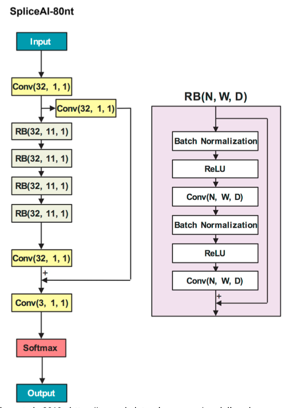
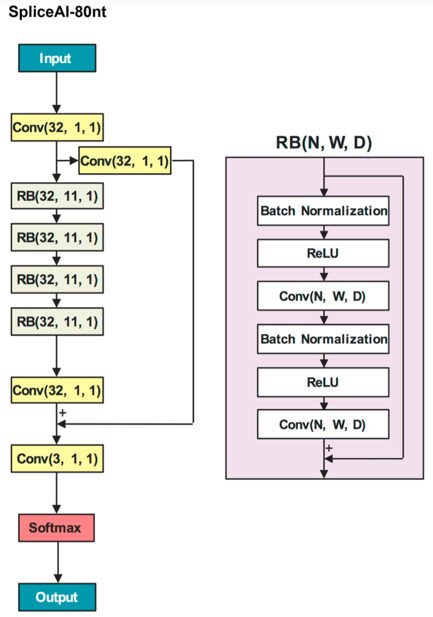

In [5]:
#### YOUR MODEL CODE HERE ####
class ResBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel_size=1, padding="same", dilation=1, p_drop=0.0):
        # self.drop = nn.Dropout2d(p_drop) if p_drop > 0 else nn.Identity()
        super().__init__()
        self.path = nn.Sequential(
            nn.BatchNorm1d(c_in),
            nn.ReLU(inplace=True),
            nn.Conv1d(c_in,c_out, kernel_size=kernel_size, padding=padding, dilation=dilation),
            nn.BatchNorm1d(c_out),
            nn.ReLU(inplace=True),
            nn.Conv1d(c_out,c_out, kernel_size=kernel_size, padding=padding, dilation=dilation))

    def forward(self, x):
        x = self.path(x) + x
        return x


In [6]:
class SpliceAI(nn.Module):
    """
    Input:  (N, 4, 7000)  # one-hot A,C,G,T (already transposed)
    Output: (N, 3, 5000)  # logits for [neither, donor, acceptor]
    SpliceAI 2k와 같은 모델 구조
    """
    def __init__(self, out_len=5000):
        super().__init__()
        self.out_len = out_len # 예측할 연속된 nucleotide
        self.stem = nn.Conv1d(in_channels=4, out_channels=48, kernel_size=1, dilation=1)
        self.conv = nn.Conv1d(in_channels=48, out_channels=48, kernel_size=1, dilation=1)
        self.final = nn.Conv1d(in_channels=48, out_channels=3, kernel_size=1, dilation=1)
        # AGCT라 in channel=4

        self.phase1 = nn.Sequential(
            ResBlock(48, 48, kernel_size=11, dilation=1),
            ResBlock(48, 48, kernel_size=11, dilation=1),
            ResBlock(48, 48, kernel_size=11, dilation=1),
            ResBlock(48, 48, kernel_size=11, dilation=1),
        )

        self.phase2 = nn.Sequential(
            ResBlock(48, 48, kernel_size=11, dilation=4),
            ResBlock(48, 48, kernel_size=11, dilation=4),
            ResBlock(48, 48, kernel_size=11, dilation=4),
            ResBlock(48, 48, kernel_size=11, dilation=4),
        )

        self.phase3 = nn.Sequential(
            ResBlock(48, 48, kernel_size=21, dilation=10),
            ResBlock(48, 48, kernel_size=21, dilation=10),
            ResBlock(48, 48, kernel_size=21, dilation=10),
            ResBlock(48, 48, kernel_size=21, dilation=10),
        )

        # self.phase4 = nn.Sequential(
        #     ResBlock(32, 32, kernel_size=41, dilation=25),
        #     ResBlock(32, 32, kernel_size=41, dilation=25),
        #     ResBlock(32, 32, kernel_size=41, dilation=25),
        #     ResBlock(32, 32, kernel_size=41, dilation=25),
        # )

    def center_crop_1d(self, x): # 중간 label 추출
        out_len = self.out_len
        L = x.size(-1)    # 마지막 차원 길이
        start = (L - out_len) // 2
        return x[..., start:start+out_len]


    def forward(self, x):
        x = self.stem(x)
        residual = self.conv(x)
        x = self.phase1(x)
        residual = residual + self.conv(x)
        x = self.phase2(x)
        residual = residual + self.conv(x)
        x = self.phase3(x)
        residual = residual + self.conv(x)

        x = residual + self.conv(x)
        x = self.final(x)

        logits = self.center_crop_1d(x)

        return logits


In [7]:
def count_params(m):
    return sum(p.numel() for p in m.parameters())

# Sanity check
print(f"Params: {count_params(SpliceAI()):,}")

Params: 798,771


### Set training configurations

Set up training configurations as you wish. Some of the configurations you may want to set here are:

 * Number of training epochs
 * Training batch size
 * Learning rate (and scheduler)
 * Optimizer
 * Weight decay and Dropout (or whether to use them)
 * Loss function

In [8]:
#### YOUR TRAINING CONFIGURATION HERE ####
def accuracy(logits, y):
    with torch.no_grad():
        if y.dim() == 3:                  # one-hot -> index
            y = y.argmax(dim=1)           # (B, 5000)
        pred = logits.argmax(dim=1)       # (B, 5000)
    return (pred == y).float().mean().item()

def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    t_loss, t_acc = 0.0, 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc  += accuracy(outputs, labels)

    t_loss /= len(train_loader)
    t_acc /= len(train_loader)

    return t_loss, t_acc

def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc  += accuracy(outputs, labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

    return val_loss, val_acc


def fit(model, optimizer, train_loader, val_loader, epochs, scheduler=None):
    best_state = None
    model.apply(lambda m: isinstance(m, (nn.Conv1d, nn.Linear)) and m.reset_parameters()) # 모델 가중치 초기화
    hist = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    criterion = nn.CrossEntropyLoss()
    pbar = tqdm(range(epochs))
    for ep in pbar:
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        if scheduler is not None:
            scheduler.step()
        v_loss, v_acc = evaluate(model, val_loader, criterion)
        hist["train_loss"].append(t_loss); hist["train_acc"].append(t_acc)
        hist["val_loss"].append(v_loss);  hist["val_acc"].append(v_acc)
        desc = f"T loss {t_loss:.3f} | T acc {t_acc:.3f} | V loss {v_loss:.3f} | V acc {v_acc:.3f}"
        pbar.set_description(desc)
        if ep == 0 or v_acc > max(hist["val_acc"][:-1]):
            best_state = model.state_dict()
    model.load_state_dict(best_state)
    return hist


### Run training
Set up and run the training loop. Use the given training and validation sets. Do not use the test set here.\
\
**Requirements (for plotting):**
 * Record training and validation losses after each epoch. Make global variables `train_loss_history` and `val_loss_history` (both are lists) containing the losses of each epoch in chronological order.
 * Use `load_datasets` to load .npz file into a global variable `data_dict`. You can find the path of the .npz file following the instruction in the Week 11 slide. Typically, it will be: `/kaggle/input/snu-aibio-mission4/snu-aibio-mission4.npz`
 * Your final, trained model object should be a global variable `final_model`.

In [9]:
#### YOUR TRAINING CODE HERE ####
train_loss_history = []
val_loss_history = []
data_dict = load_datasets("/Users/martin/Desktop/PythonWorkSpace/spliceai_data/snu-aibio-mission4.npz")
print(data_dict['train_x'].shape)
print(data_dict['train_y'].shape)
print(data_dict.keys())

final_model = None
# shape (N, 4, 7000)으로, i.e. (채널,행) 으로 바꾸어 주어야 함.
# (0,2,1) transpose는 create_dataloader함수 안에서 처리.

(16076, 7000, 4)
(16076, 5000, 3)
dict_keys(['train_x', 'train_y', 'validation_x', 'validation_y', 'test_x', 'test_y'])


In [10]:
# create data loader
batch_size = 12
train_loader = create_dataloader(data_dict, 'train', batch_size=batch_size)
val_loader = create_dataloader(data_dict, 'validation', batch_size=batch_size)
test_loader = create_dataloader(data_dict, 'test', batch_size=batch_size)

print(f"[Batch count] Train: {len(train_loader)} / Val: {len(val_loader)} / Test: {len(test_loader)}")

[Batch count] Train: 1339 / Val: 155 / Test: 698


#### SpliceAI 2k base model test

In [ ]:
# scheduler step
def lr_lambda(epoch):
    return 1.0 if epoch < 6 else 0.5 ** (epoch - 5)

In [11]:
# # SpliceAI
# # hist = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
LR = 1e-3
out_len = 5000 # 예측할 nuc 개수
EPOCH = 10
model = SpliceAI(out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0, betas=(0.9, 0.999), eps=1e-8)
# Adam default 값 사용
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# hist = fit(model, optimizer, train_loader, val_loader, epochs=EPOCH, scheduler=scheduler)
# train_loss_history = hist['train_loss']
# val_loss_history = hist['val_loss']
#
# final_model = model # 이미 fit()함수에서 model에 best state 덮어씀

#### LR search

In [15]:
import pandas as pd

def lr_search(lr_space = np.logspace(-2, -6, num=5),
              l2 = 3e-5,
              epochs = 10,
              num_classes = 3):

    # 각 learning rate마다 micro acc(기존) + per-class acc + macro acc 저장
    opt_dict = {
        "lr": [],
        "val_acc_micro": [],   # 기존 hist["val_acc"] (전체 accuracy)
        "val_acc_macro": []    # calculate_accuracy에서 나온 class-wise 평균
    }
    for c in range(num_classes):
        opt_dict[f"val_acc_class{c}"] = []

    for lr in lr_space:
        model = SpliceAI().to(device)
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=l2,
            betas=(0.9, 0.999),
            eps=1e-8
        )
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
        hist = fit(model, optimizer, train_loader, val_loader, epochs, scheduler=scheduler)

        # (1) 기존 전체 acc (micro) – 에포크 중 최고값
        val_acc_micro = np.max(hist["val_acc"])
        # (2) validation set 전체에 대해 logits & labels 모아서 per-class acc 계산
        model.eval()
        all_y = []
        all_logits = []
        with torch.no_grad():
            for xs, ys in val_loader:
                xs = xs.to(device=device, dtype=torch.float32)
                ys = ys.to(device=device, dtype=torch.float32)

                logits = model(xs)

                all_y.append(ys.cpu())
                all_logits.append(logits.cpu())

        all_y = torch.cat(all_y, dim=0)        # (N, C, L)
        all_logits = torch.cat(all_logits, dim=0)

        # one-hot -> index, 그리고 1D로 flatten
        true_classes = all_y.argmax(dim=1).numpy().ravel()      # (N*L,)
        pred_classes  = all_logits.argmax(dim=1).numpy().ravel()

        class_accuracies, overall_accuracy = calculate_accuracy(
            true_classes, pred_classes, num_classes=num_classes
        )

        # dict에 저장
        opt_dict["lr"].append(lr)
        opt_dict["val_acc_micro"].append(val_acc_micro)
        opt_dict["val_acc_macro"].append(overall_accuracy)
        for c in range(num_classes):
            opt_dict[f"val_acc_class{c}"].append(class_accuracies[c])

    return pd.DataFrame(opt_dict)


def plot_lr_search(opt_df, class_names=None):
    """
    opt_df: lr_search에서 반환한 DataFrame
    class_names: ['non-splice', 'donor', 'acceptor'] 같이 넣어주면 라벨에 사용
                 안 주면 'class0', 'class1', ... 형태로 표시
    """
    # per-class 컬럼 이름들 정리
    class_cols = [c for c in opt_df.columns if c.startswith("val_acc_class")]
    class_cols = sorted(class_cols, key=lambda x: int(x.replace("val_acc_class", "")))

    if class_names is None:
        class_names = [f"class {i}" for i in range(len(class_cols))]

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # macro / micro 둘 다 보고 싶으면 둘 다 그리기
    if "val_acc_micro" in opt_df.columns:
        ax.plot(opt_df["lr"], opt_df["val_acc_micro"],
                marker="o", linestyle="-", label="micro acc (overall)")
    if "val_acc_macro" in opt_df.columns:
        ax.plot(opt_df["lr"], opt_df["val_acc_macro"],
                marker="o", linestyle="-.", label="macro acc (mean per class)")

    # per-class curves
    for col, name in zip(class_cols, class_names):
        ax.plot(opt_df["lr"], opt_df[col],
                marker="o", linestyle="--", label=f"{name}")

    ax.set_title("Validation per-class accuracy vs learning rate")
    ax.set_xlabel("Learning rate")
    ax.set_ylabel("Accuracy")
    ax.set_xscale("log")
    ax.legend()
    plt.tight_layout()
    plt.show()
    return None

T loss 0.001 | T acc 1.000 | V loss 0.001 | V acc 1.000: 100%|██████████| 10/10 [39:10<00:00, 235.00s/it]
T loss 0.000 | T acc 1.000 | V loss 0.000 | V acc 1.000: 100%|██████████| 10/10 [35:35<00:00, 213.57s/it]
T loss 0.000 | T acc 1.000 | V loss 0.000 | V acc 1.000: 100%|██████████| 10/10 [35:30<00:00, 213.08s/it]
T loss 0.001 | T acc 1.000 | V loss 0.001 | V acc 1.000: 100%|██████████| 10/10 [35:41<00:00, 214.16s/it]
T loss 0.002 | T acc 1.000 | V loss 0.002 | V acc 1.000: 100%|██████████| 10/10 [35:41<00:00, 214.14s/it]


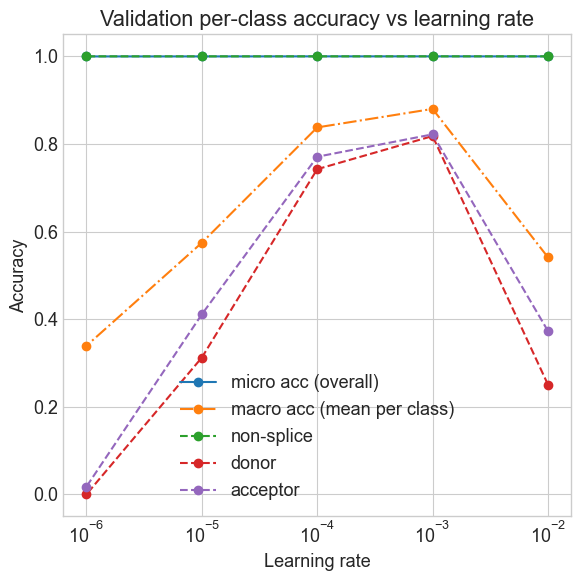

In [22]:
opt_df = lr_search()
plot_lr_search(opt_df, class_names=["non-splice", "donor", "acceptor"])

#### Random search search of LR and L2 (weight decay)

In [17]:
import pandas as pd

def hpo(lr_scope, l2_scope, epochs=10, trials=10, num_classes=3):
    """
    lr_scope: [log10_min, log10_max]
    l2_scope: [log10_min, log10_max]
    예: [-4.0, -2.0] -> 10**U(-4, -2)
    trials: random search 횟수 (기본 10개 point)
    """

    opt_dict = {
        "lr": [],
        "l2": [],
        "val_acc_micro": [],   # hist["val_acc"]의 best (전체 accuracy)
        "val_acc_macro": []    # per-class accuracy 평균
    }
    for c in range(num_classes):
        opt_dict[f"val_acc_class{c}"] = []

    for i in range(trials):
        # log-uniform sampling
        lr = 10 ** np.random.uniform(*lr_scope)
        l2 = 10 ** np.random.uniform(*l2_scope)

        model = SpliceAI().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

        # 학습
        hist = fit(model, optimizer, train_loader, val_loader, epochs=epochs, scheduler=scheduler)


        # 1. micro acc: 에포크 중 최고 validation acc
        val_acc_micro = np.max(hist["val_acc"])

        # 2. validation 전체에 대해 per-class acc 계산
        model.eval()
        all_y = []
        all_logits = []
        with torch.no_grad():
            for xs, ys in val_loader:
                xs = xs.to(device=device, dtype=torch.float32)
                ys = ys.to(device=device, dtype=torch.float32)

                logits = model(xs)

                all_y.append(ys.cpu())
                all_logits.append(logits.cpu())

        all_y = torch.cat(all_y, dim=0)        # (N, C, L)
        all_logits = torch.cat(all_logits, dim=0)

        true_classes = all_y.argmax(dim=1).numpy().ravel()   # (N*L,)
        pred_classes  = all_logits.argmax(dim=1).numpy().ravel()

        # 이미 만들어둔 함수 사용(true, pred, num_classes)
        class_accuracies, overall_accuracy = calculate_accuracy(
            true_classes,
            pred_classes,
            num_classes=num_classes
        )

        # 결과 저장
        opt_dict["lr"].append(lr)
        opt_dict["l2"].append(l2)
        opt_dict["val_acc_micro"].append(val_acc_micro)
        opt_dict["val_acc_macro"].append(overall_accuracy)
        for c in range(num_classes):
            opt_dict[f"val_acc_class{c}"].append(class_accuracies[c])

    return pd.DataFrame(opt_dict)

In [18]:
def plot_hpo(opt_df, steps=100, x="lr", y="l2", metric="val_acc_macro"):
    """
    metric: 'val_acc_micro', 'val_acc_macro', 'val_acc_class0' 등 opt_df 컬럼 이름
    """

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_title(f"Validation {metric}")

    z = opt_df[metric].values
    z_min, z_max = np.min(z), np.max(z)

    # contour level 간격
    if steps <= 0 or z_max == z_min:
        acc_step = 0.01
    else:
        acc_step = (z_max - z_min) / steps

    levels = np.arange(z_min, z_max + acc_step, acc_step)

    pcm = ax.tricontourf(
        np.log10(opt_df[x]),
        np.log10(opt_df[y]),
        z,
        levels=levels,
        vmin=max(0.5, z_min)
    )

    ax.scatter(np.log10(opt_df[x]), np.log10(opt_df[y]), color="black")

    ax.set_xlabel(f"log10({x})")
    ax.set_ylabel(f"log10({y})")

    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(metric)

    plt.tight_layout()
    plt.show()
    return None

T loss 0.001 | T acc 1.000 | V loss 0.000 | V acc 1.000: 100%|██████████| 10/10 [35:18<00:00, 211.88s/it]
T loss 0.000 | T acc 1.000 | V loss 0.000 | V acc 1.000: 100%|██████████| 10/10 [35:11<00:00, 211.20s/it]
T loss 0.000 | T acc 1.000 | V loss 0.000 | V acc 1.000: 100%|██████████| 10/10 [35:22<00:00, 212.26s/it]
T loss 0.000 | T acc 1.000 | V loss 0.000 | V acc 1.000: 100%|██████████| 10/10 [35:14<00:00, 211.45s/it]
T loss 0.000 | T acc 1.000 | V loss 0.000 | V acc 1.000: 100%|██████████| 10/10 [35:12<00:00, 211.21s/it]
T loss 0.000 | T acc 1.000 | V loss 0.000 | V acc 1.000: 100%|██████████| 10/10 [35:15<00:00, 211.57s/it]
T loss 0.000 | T acc 1.000 | V loss 0.000 | V acc 1.000: 100%|██████████| 10/10 [35:11<00:00, 211.20s/it]
T loss 0.000 | T acc 1.000 | V loss 0.000 | V acc 1.000: 100%|██████████| 10/10 [35:48<00:00, 214.86s/it]
T loss 0.000 | T acc 1.000 | V loss 0.000 | V acc 1.000: 100%|██████████| 10/10 [35:45<00:00, 214.59s/it]
T loss 0.000 | T acc 1.000 | V loss 0.000 | V 

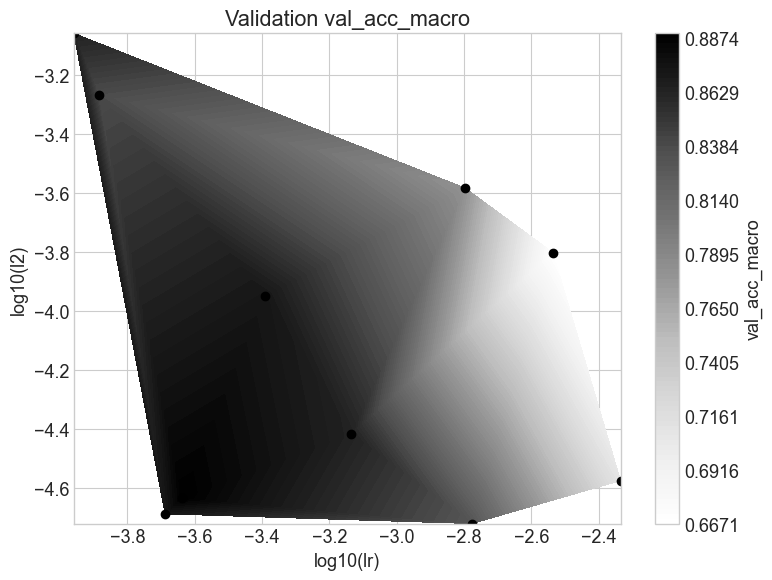

,lr,l2,val_acc_micro,val_acc_macro,val_acc_class0,val_acc_class1,val_acc_class2
0,0.002911,0.000158,0.999846,0.667128,0.999968,0.464380,0.537037
1,0.000205,0.000021,0.999928,0.872295,0.999974,0.807388,0.809524
2,0.000131,0.000540,0.999928,0.838260,0.999987,0.741425,0.773369
3,0.001593,0.000261,0.999872,0.781924,0.999952,0.613896,0.731922
4,0.000110,0.000871,0.999933,0.863788,0.999983,0.790677,0.800705
5,0.004623,0.000027,0.999861,0.708510,0.999967,0.537379,0.588183
6,0.000231,0.000023,0.999932,0.889606,0.999972,0.842568,0.826279
7,0.000406,0.000112,0.999926,0.872287,0.999973,0.816183,0.800705
8,0.000731,0.000038,0.999924,0.864081,0.999973,0.788918,0.803351
9,0.001674,0.000019,0.999896,0.830603,0.999958,0.746702,0.745150


In [19]:
lr_scope = [-4.0, -2.0] # 1e-4 ~ 1e-2
l2_scope = [-5.0, -3.0] # 1e-5 ~ 1e-3
opt_df = hpo(lr_scope, l2_scope, epochs = 10)
plot_hpo(opt_df)
opt_df

### final model

In [12]:
# Base on hypo search
final_LR = 0.000231
final_L2 = 0.000023


In [13]:
# SpliceAI
# hist = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
out_len = 5000 # 예측할 nuc 개수
EPOCH = 15

model = SpliceAI(out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=final_LR, weight_decay=final_L2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

hist = fit(model, optimizer, train_loader, val_loader, epochs=EPOCH, scheduler=scheduler)
train_loss_history = hist['train_loss']
val_loss_history = hist['val_loss']

final_model = model # 이미 fit()함수에서 model에 best state 덮어쓴 상태.

T loss 0.000 | T acc 1.000 | V loss 0.000 | V acc 1.000: 100%|██████████| 15/15 [54:23<00:00, 217.57s/it]


### Visualize training curve

**DO NOT MODIFY the code below.** Just run it after training has finished.


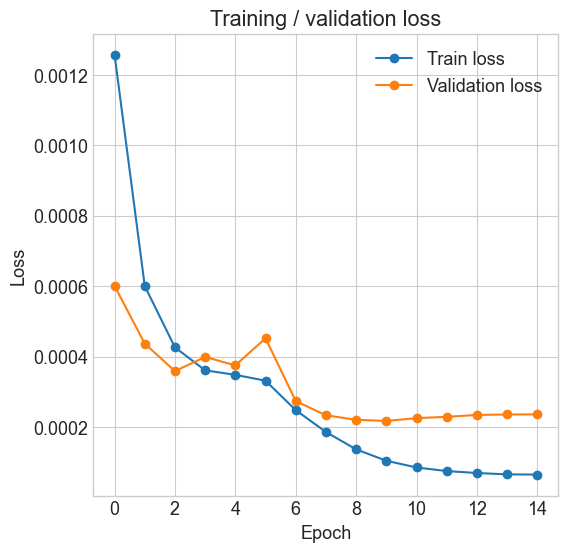

In [14]:
def plot_training_curve(train_loss_history, val_loss_history):
    assert len(train_loss_history) == len(val_loss_history)
    epochs = range(len(train_loss_history))
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, train_loss_history, marker='o', label='Train loss')
    plt.plot(epochs, val_loss_history, marker='o', label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training / validation loss')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_training_curve(train_loss_history, val_loss_history)

### Evaluate performance on the test set

**DO NOT MODIFY the code below.** Just run it after training has finished. You may edit the `batch_size` argument of `collect_logits_and_labels` if a GPU memory error occurs.


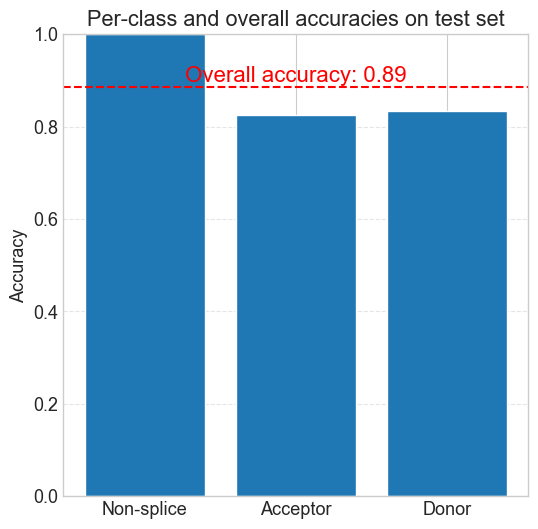

In [15]:
def collect_logits_and_labels(model, data_dict, split, batch_size, device=device):
    model.eval()
    all_y = []
    all_logits = []
    loader = create_dataloader(data_dict, split, batch_size)
    with torch.no_grad():
        for xs, ys in loader:
            xs = xs.to(device=device, dtype=torch.float32)
            ys = ys.to(device=device, dtype=torch.float32)
            logits = model(xs)
            all_y.append(ys.cpu())
            all_logits.append(logits.cpu())
    all_y = torch.cat(all_y, dim=0)
    all_logits = torch.cat(all_logits, dim=0)
    return all_y, all_logits

def plot_accuracy(y, logits):
    true_classes = y.argmax(dim=1).numpy().reshape(-1)
    pred_classes = logits.argmax(dim=1).numpy().reshape(-1)
    class_accuracies, overall_accuracy = calculate_accuracy(true_classes, pred_classes, 3)

    ss_types = ["Non-splice", "Acceptor", "Donor"]
    plt.figure(figsize=(6, 6))
    plt.bar(ss_types, class_accuracies)
    plt.axhline(y=overall_accuracy, color="r", linestyle="--")
    plt.ylim(0.0, 1.0)
    plt.ylabel("Accuracy")
    plt.title("Per-class and overall accuracies on test set")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.text(1, overall_accuracy+0.01,
             f"Overall accuracy: {overall_accuracy:.2f}", fontsize=16,
             horizontalalignment="center", color="r")
    plt.show()
    return None

y_test, logits_test = collect_logits_and_labels(final_model, data_dict, 'test', batch_size = batch_size)
plot_accuracy(y_test, logits_test)

### Inspect example sequences (qualitative analysis)

**DO NOT MODIFY the code below.** Just run it after training has finished.\
You may draw additional plots using `plot_splice_sequence` by adjusting `example_index` and `window` if you want to inspect the results, but please remove them before submitting the notebook.

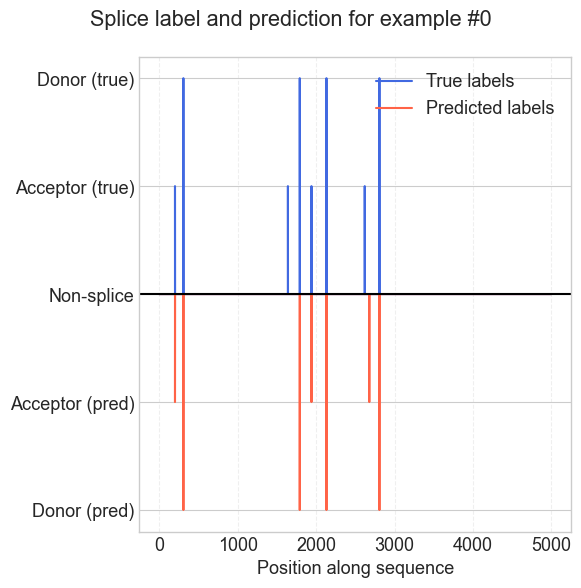

In [16]:
def plot_splice_sequence(y, logits, example_index=0, window=None):
    """
    y: tensor of shape (N, 3, T)
    logits: tensor of shape (N, 3, T)
    example_index: which sequence to plot
    window: tuple (start, end) to zoom into a region (optional)
    """
    y_true = y[example_index].argmax(dim=0).numpy()
    y_pred = logits[example_index].argmax(dim=0).numpy()
    positions = np.arange(len(y_true))

    if window is not None:
        start, end = window
        positions = positions[start:end]
        y_true = y_true[start:end]
        y_pred = y_pred[start:end]

    fig = plt.figure(figsize=(6, 6))
    plt.step(positions, y_true, where='mid', label='True labels', color="royalblue")
    plt.step(positions, -y_pred, where='mid', label='Predicted labels', color="tomato")
    plt.yticks([-2, -1, 0, 1, 2], ["Donor (pred)", "Acceptor (pred)", "Non-splice", "Acceptor (true)", "Donor (true)"])
    plt.axhline(0, color="k")
    plt.xlabel("Position along sequence")
    plt.legend(loc='upper right')
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    fig.suptitle(f"Splice label and prediction for example #{example_index}")
    plt.tight_layout()
    plt.show()

plot_splice_sequence(y_test, logits_test, example_index=0, window=None)


### Mission report (to be filled before submission)

After you have finished your experiments, please fill in the short report below to organize your results. Please write directly in this cell.

**1. Final training configuration**

 * Optimizer:
 * Loss function:
 * Epochs:
 * Batch Size:
 * Learning Rate:
 * Scheduler:
 * Weight Decay:
 * Dropout:
 * Other important settings (if any):

**2. Final model configuration**

 * Number of convolution layers:
 * Total parameter count:
 * Base architecture (ResNet, ResNext, Inception, ...):
 * Kernel size (if multiple, list all):
 * Dilation factor (if multiple, list all):
 * Other important settings (if any):

**3. Final performance**

 * Test set overall accuracy:

**4. What you tried**

Briefly describe different configurations you tried
(e.g. different schedulers, learning rate, regularization, architecture) and
what happened in each case.

Example (These are just arbitrary examples unrelated to the mission. Erase them and write yours.):
 * Config 1: ResNet (1M parameters), OneCycleLR → fast initial improvement but underfitting.
 * Config 2: ResNet (1M parameters), CosineAnnealing → slower but better accuracy.
 * Config 3: ResNext (1M parameters), CosineAnnealing → Better accuracy than ResNet.

**5. Short interpretation**

In 3–5 sentences, summarize what you learned from this mission,
and explain why the final model & training configurations were chosen.

